In [4]:
import os
import sys

In [5]:
cur_root_dir = os.getcwd()
print("Current root dir is {}".format(cur_root_dir))
if cur_root_dir not in sys.path:
    sys.path.append(cur_root_dir)

Current root dir is /home/framos/Code/bayes_sim


In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
from src.models.MDN import MDNN, MDRFF, MDLSTM, MDRFFLSTM
from src.models.BayesSim import BayesSim
from src.data.PendulumDataGenerator import PendulumDataGenerator
from src.utils.param_inference import *
import pickle
import numpy as np
import matplotlib.pyplot as plt

ImportError: No module named 'src.models.MDN'

# Inference on Pendulum Mass and length

### Loading simulation data from file

The FrankaDataGenerator is responsible for running the forward model with priors sampled from an uniform distribution with the believed range of the actual values.

In order to collect data we assume:
    - There is a controller/policy of which you can run your forward model (simulation) with.
    - You are able to calculate some sufficient statistics from your trajectories. In our case we use a Reinforcement Learning policy that we calculate cross-correlation
    - You have some understanding of the prior parameters of your simulation. For instance, you know that a specific parameter can't go below or over some threshold

In [6]:
policy_file = os.path.join(cur_root_dir, "src","models","controllers","PPO", "Pendulum-v0.pkl")
g = PendulumDataGenerator(policy_file=policy_file)

Loading a model without an environment, this model cannot be trained until it has a valid environment.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Summary name model/pi_fc0/w:0 is illegal; using model/pi_fc0/w_0 instead.
INFO:tensorflow:Summary name model/pi_fc0/b:0 is illegal; using model/pi_fc0/b_0 instead.
INFO:tensorflow:Summary name model/vf_fc0/w:0 is illegal; using model/vf_fc0/w_0 instead.
INFO:tensorflow:Summary name model/vf_fc0/b:0 is illegal; using model/vf_fc0/b_0 instead.
INFO:tensorflow:Summary name model/pi_fc1/w:0 is illegal; using model/pi_fc1/w_0 instead.
INFO:tensorflow:Summary name model/pi_fc1/b:0 is illegal; using model/pi_fc1/b_0 instead.
INFO:tensorflow:Summary name model/vf_fc1/w:0 is illegal; using model/vf_fc1/w_0 instead.
INFO:tensorflow:Summary name model/vf_fc1/b:0 is illegal; using model/vf_fc1/b_0 inste

In [7]:
params, stats = g.gen(1)
shapes = {"params": params.shape[1], "data": stats.shape[1]}

print("Total data size: {}".format(params.shape[0]))

100%|██████████| 1/1 [00:00<00:00, 13.85it/s]


Drawing Parameters and Running simulation...
Total data size: 1


### Training the model using a Mixture of Density network

We train a mixture of density network / mixture of density random fourier features where the inputs are the sufficient statistics calculated from the data and the output are the weights, means and variances of the Mixture of Gaussians

  0%|          | 3/1000 [00:00<00:39, 25.20it/s]


Drawing Parameters and Running simulation...


100%|██████████| 1000/1000 [00:48<00:00, 20.48it/s]


Training model....

*********************************  End  *********************************

Duration: 0:00:57.903148


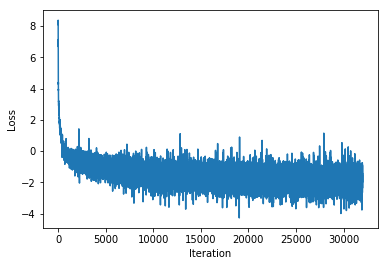

In [8]:
log_mdn, inf_mdn = train(epochs=1000, batch_size=32, params_dim=2, stats_dim=9, num_sampled_points=1000,
                         generator=g, model="MDRFFLSTM", n_components=10)

### Training the Model using a Mixture of Density Random Fourier Features

Data has already been generated, loading from memory...

*********************************  End  *********************************

Duration: 0:01:02.146599


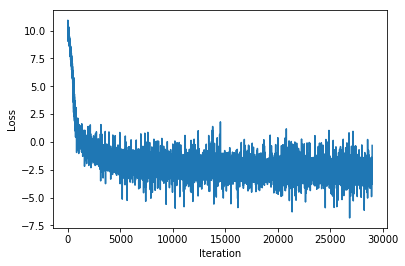

In [14]:
log_rff, inf_rff = train(epochs=1000, batch_size=32, params_dim=2, stats_dim=9, num_sampled_points=1000,
                         generator=g, model="MDRFF", n_components=2)

### Recovering the posterior from a specific stiffness parameter

Now you can either run an experiment in the real robot or collect trajectories for a specific value of your dynamics parameter. You can then input the sufficient statistics of these trajectories in Bayes Sim and it will recover your full posterior over the chosen parameter

### MDN

In [10]:
true_obs = np.array([[1.0, 1.5]])

Scaled true obs: [[1.  1.5]]
Params: [1.  1.5]


*********************************  Prediction ends  *********************************


Duration: 0:00:00.059814
component 1: mixture weight = 0.0117; mean = 0.7231; variance = 0.0006
component 2: mixture weight = 0.9883; mean = 0.9973; variance = 0.0002
component 1: mixture weight = 0.0117; mean = 1.9251; variance = 0.0152
component 2: mixture weight = 0.9883; mean = 1.6194; variance = 0.0365


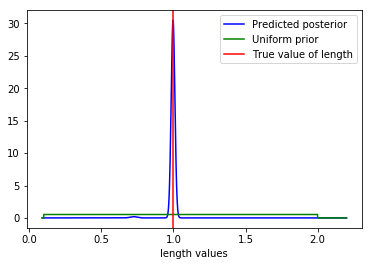

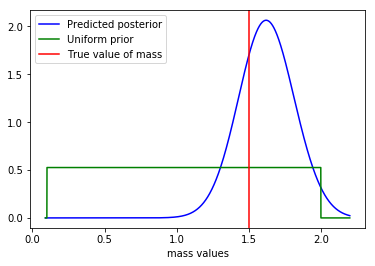

In [11]:
get_results_from_true_obs(env_params=["length", "mass"], true_obs=true_obs, generator=g, inf=inf_mdn, shapes=shapes,
                          p_lower=[0.1, 0.1], p_upper=[2.0, 2.0])

### MDRFF

Scaled true obs: [[1.  1.5]]
Params: [1.  1.5]


*********************************  Prediction ends  *********************************


Duration: 0:00:00.080045
component 1: mixture weight = 0.5205; mean = 0.9960; variance = 0.0000
component 2: mixture weight = 0.4795; mean = 0.9818; variance = 0.0000
component 1: mixture weight = 0.5205; mean = 1.8484; variance = 0.0147
component 2: mixture weight = 0.4795; mean = 1.5046; variance = 0.0005


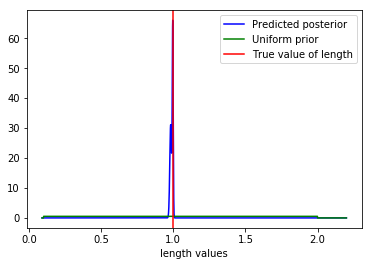

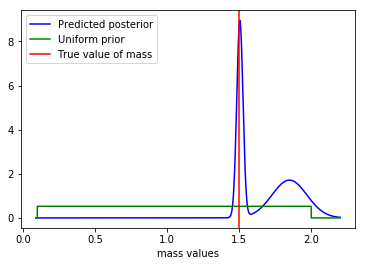

In [15]:
get_results_from_true_obs(env_params=["length", "mass"], true_obs=true_obs, generator=g, inf=inf_rff, shapes=shapes,
                          p_lower=[0.1, 0.1], p_upper=[2.0, 2.0])